In [19]:
#Data import and preparation
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
import pandas as pd
from pyspark.sql.functions import *
from pyspark.sql.functions import month
from pyspark.sql.types import *
spark = SparkSession.builder.appName('Movie Ratings').getOrCreate()
 

df = spark.read.csv('merged_movies_ratings_updated.csv', header=True, inferSchema=True)
 

df.show(5)

+------+-------+------+----------+--------------------+--------------------+
|userId|movieId|rating| timestamp|               title|              genres|
+------+-------+------+----------+--------------------+--------------------+
|     1|    296|   5.0|1147880044| Pulp Fiction (1994)|Comedy|Crime|Dram...|
|     1|    306|   3.5|1147868817|Three Colors: Red...|               Drama|
|     1|    307|   5.0|1147868828|Three Colors: Blu...|               Drama|
|     1|    665|   5.0|1147878820|  Underground (1995)|    Comedy|Drama|War|
|     1|    899|   3.5|1147868510|Singin' in the Ra...|Comedy|Musical|Ro...|
+------+-------+------+----------+--------------------+--------------------+
only showing top 5 rows



In [2]:
#Goal 1: Personalized recommendations
highest_rated_movies = df.groupBy("title").agg(
    avg("rating").alias("average_rating"),
    count("rating").alias("rating_count")
).filter("rating_count > 10")  
highest_rated_movies_sorted = highest_rated_movies.orderBy(desc("average_rating"))
print("Top-rated movies:")
highest_rated_movies_sorted.show(10, truncate=False)

Top-rated movies:
+------------------------------------------------+-----------------+------------+
|title                                           |average_rating   |rating_count|
+------------------------------------------------+-----------------+------------+
|Planet Earth II (2016)                          |4.6              |25          |
|Planet Earth (2006)                             |4.514705882352941|34          |
|Departures (Okuribito) (2008)                   |4.5              |16          |
|Whiplash (2013)                                 |4.476190476190476|21          |
|Ghost in the Shell 2.0 (2008)                   |4.472222222222222|18          |
|Interstate 60 (2002)                            |4.428571428571429|21          |
|Shawshank Redemption, The (1994)                |4.422853828306264|1724        |
|You Can't Take It with You (1938)               |4.416666666666667|12          |
|Song of the Little Road (Pather Panchali) (1955)|4.392857142857143|14          


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\S564560\AppData\Local\Temp\ipykernel_5152\2823831136.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='average_rating', y='title', data=top_movies_pd, palette='viridis')


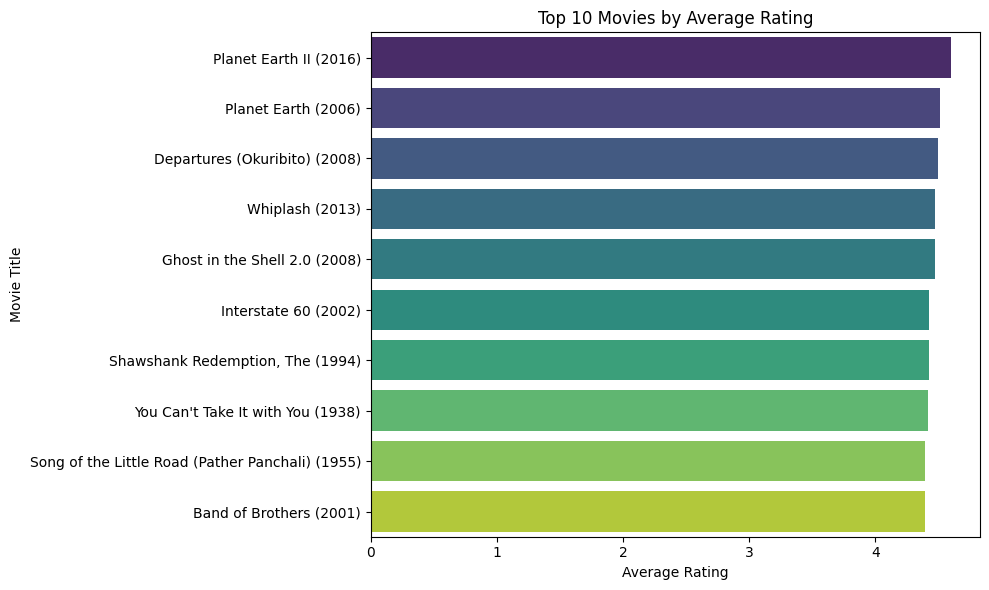

In [3]:
# Bargraph 1: Personalized recommendations
!pip install matplotlib seaborn
import matplotlib.pyplot as plt
import seaborn as sns


top_movies_pd = highest_rated_movies_sorted.limit(10).toPandas()


plt.figure(figsize=(10, 6))
sns.barplot(x='average_rating', y='title', data=top_movies_pd, palette='viridis')


plt.xlabel('Average Rating')
plt.ylabel('Movie Title')
plt.title('Top 10 Movies by Average Rating')


plt.tight_layout()
plt.show()


In [4]:
#Goal 2 Improved Recommndation Accuracy by Analysing user behavior
most_active_users = df.groupBy("userId").agg(
    count("movieId").alias("movies_rated")
).orderBy(desc("movies_rated"))
print("Most active users:")
most_active_users.show(10)

Most active users:
+------+------------+
|userId|movies_rated|
+------+------------+
|  2177|        4227|
|   548|        3212|
|  1748|        3193|
|   847|        2920|
|  2982|        2803|
|  3150|        2686|
|   997|        2371|
|  1920|        2328|
|  1977|        1907|
|   626|        1888|
+------+------------+
only showing top 10 rows



C:\Users\S564560\AppData\Local\Temp\ipykernel_5152\2256863531.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='userId', y='movies_rated', data=most_active_users_pd, palette='coolwarm')


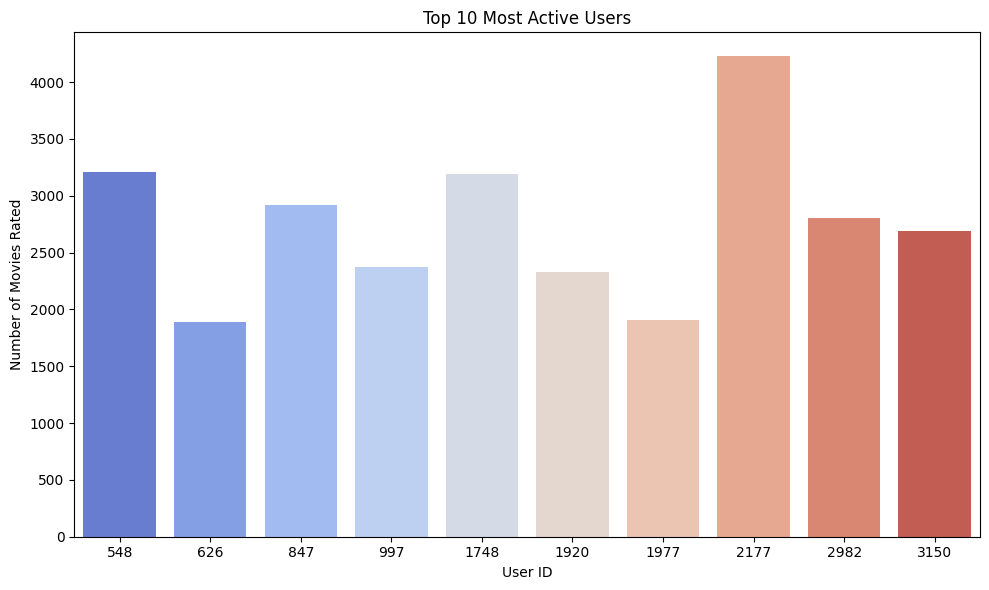

In [6]:
# Bargraph 2: Improved Recommndation Accuracy by Analysing user behavior

most_active_users_pd = most_active_users.limit(10).toPandas()


plt.figure(figsize=(10, 6))
sns.barplot(x='userId', y='movies_rated', data=most_active_users_pd, palette='coolwarm')


plt.xlabel('User ID')
plt.ylabel('Number of Movies Rated')
plt.title('Top 10 Most Active Users')


plt.tight_layout()
plt.show()


In [33]:
# Goal 3 Enhanced user experience

ratings_df = df.select("userId", "movieId", "rating")
movies_df = df.select("movieId", "title", "genres").distinct()


genres_df = movies_df.withColumn("genre", explode(split(col("genres"), "\\|"))).select("movieId", "title", "genre")
genres_df.show()

+-------+--------------------+---------+
|movieId|               title|    genre|
+-------+--------------------+---------+
|    745|Wallace & Gromit:...|Animation|
|    745|Wallace & Gromit:...| Children|
|    745|Wallace & Gromit:...|   Comedy|
|   1381|     Grease 2 (1982)|   Comedy|
|   1381|     Grease 2 (1982)|  Musical|
|   1381|     Grease 2 (1982)|  Romance|
|  46967|        Scoop (2006)|   Comedy|
|  46967|        Scoop (2006)|  Fantasy|
|  46967|        Scoop (2006)|  Mystery|
|   6119|Santa Claus Is a ...|   Comedy|
|   8253|Lupin III: The Ca...|   Action|
|   8253|Lupin III: The Ca...|Adventure|
|   8253|Lupin III: The Ca...|Animation|
|   8253|Lupin III: The Ca...|   Comedy|
|   8253|Lupin III: The Ca...|    Crime|
|   8253|Lupin III: The Ca...|  Mystery|
|  71438|Still Walking (Ar...|    Drama|
|   2344|Runaway Train (1985)|   Action|
|   2344|Runaway Train (1985)|Adventure|
|   2344|Runaway Train (1985)|    Drama|
+-------+--------------------+---------+
only showing top

C:\Users\S564560\AppData\Local\Temp\ipykernel_5152\1163092625.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='genre', data=genre_counts_pd, palette='viridis')


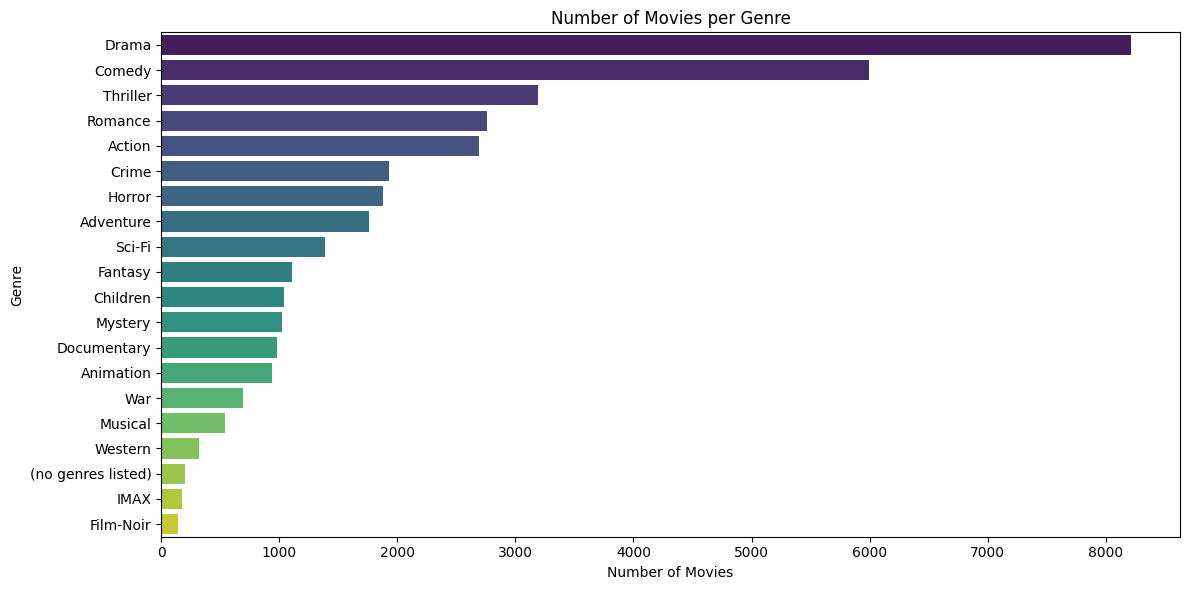

C:\Users\S564560\AppData\Local\Temp\ipykernel_5152\1163092625.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='genre', data=top_genres, palette='coolwarm')


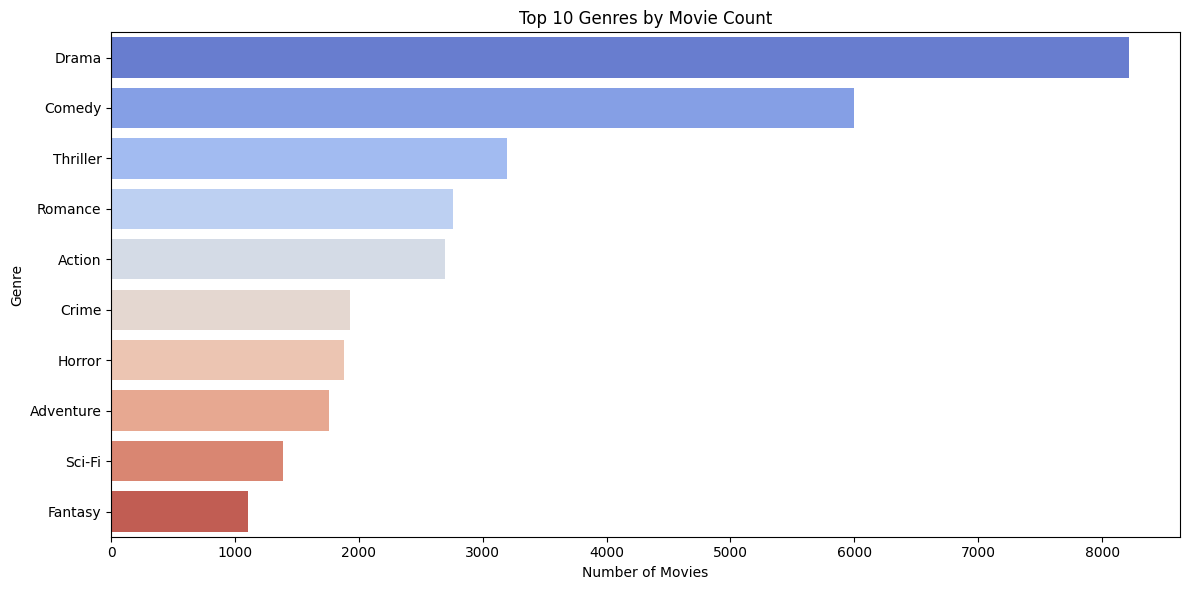

C:\Users\S564560\AppData\Local\Temp\ipykernel_5152\1163092625.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='movie_count', y='genre', data=movie_count_per_genre_pd, palette='magma')


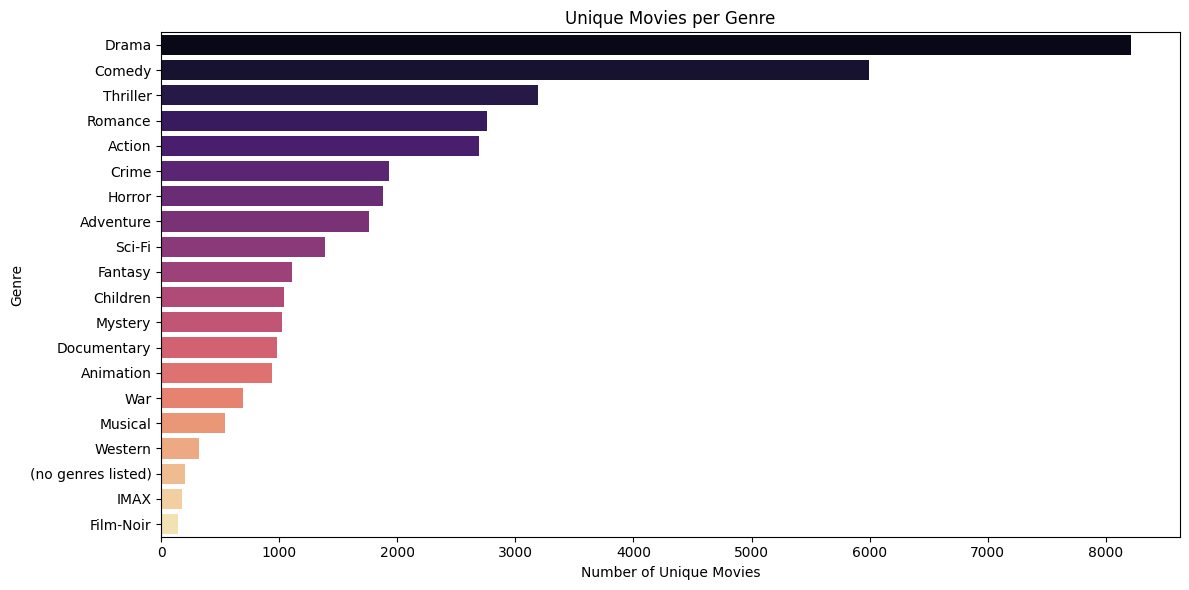

In [34]:
#Bargraph 3 Enhanced user experience 
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Count the number of movies per genre
genre_counts = genres_df.groupBy("genre").count().orderBy("count", ascending=False)
genre_counts_pd = genre_counts.toPandas()


plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='genre', data=genre_counts_pd, palette='viridis')
plt.title('Number of Movies per Genre')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

# 2. Top Genres by Movie Count

top_genres = genre_counts_pd.head(10)


plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='genre', data=top_genres, palette='coolwarm')
plt.title('Top 10 Genres by Movie Count')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

# 3. Count the number of unique movieId for each genre (just for visualization)

movie_count_per_genre = genres_df.groupBy("genre").agg(countDistinct("movieId").alias("movie_count")).orderBy("movie_count", ascending=False)
movie_count_per_genre_pd = movie_count_per_genre.toPandas()


plt.figure(figsize=(12, 6))
sns.barplot(x='movie_count', y='genre', data=movie_count_per_genre_pd, palette='magma')
plt.title('Unique Movies per Genre')
plt.xlabel('Number of Unique Movies')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()


User Similarity (Average Rating per User):
+------+------------------+
|userId|        avg_rating|
+------+------------------+
|   148| 4.128787878787879|
|   463|3.9047619047619047|
|   471| 4.051282051282051|
|   243| 2.787878787878788|
|   392| 4.638888888888889|
|    31| 2.431077694235589|
|    85|3.5441176470588234|
|   137|3.4927536231884058|
|   251| 3.074712643678161|
|   451|              4.02|
|    65| 4.132352941176471|
|   458|2.9864864864864864|
|    53|  4.62962962962963|
|   255|3.9583333333333335|
|   133|3.3461538461538463|
|   296|2.8762886597938144|
|   472| 3.519867549668874|
|    78| 4.413043478260869|
|   322| 3.411242603550296|
|   321| 3.139064475347661|
+------+------------------+
only showing top 20 rows



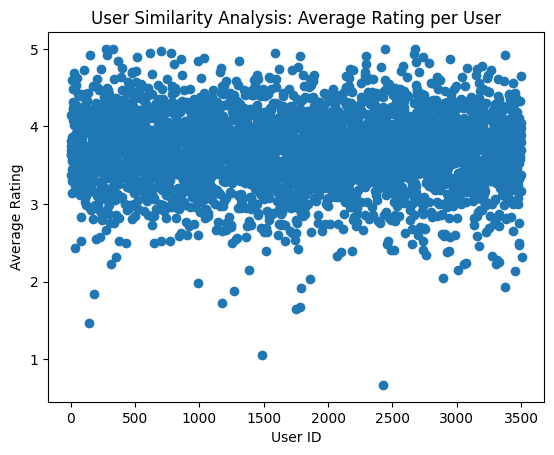

In [31]:
#Goal 4 Similarity analysis 
# 1. Calculate the average rating for each user
user_similarity = data.groupBy("userId").agg(avg("rating").alias("avg_rating"))
 

print("User Similarity (Average Rating per User):")
user_similarity.show()
 
# 2. Convert to Pandas DataFrame for visualization
user_similarity_pandas = user_similarity.toPandas()
 
# 3. Visualize user similarity using a scatter plot
plt.scatter(user_similarity_pandas['userId'], user_similarity_pandas['avg_rating'])
plt.xlabel("User ID")
plt.ylabel("Average Rating")
plt.title("User Similarity Analysis: Average Rating per User")
plt.show()


In [13]:
# Goal 5: Exploring movie recommendation by popular genres

genres_df = df.select("title", explode(split("genres", "\\|")).alias("genre"))

# Count the number of movies per genre
popular_genres = genres_df.groupBy("genre").agg(
    count("title").alias("movies_count")
).orderBy(desc("movies_count"))
print("Popular genres:")
popular_genres.show(10)

Popular genres:
+---------+------------+
|    genre|movies_count|
+---------+------------+
|    Drama|      221070|
|   Comedy|      183778|
|   Action|      151771|
| Thriller|      137301|
|Adventure|      119391|
|  Romance|       92678|
|   Sci-Fi|       87696|
|    Crime|       84579|
|  Fantasy|       57479|
| Children|       44068|
+---------+------------+
only showing top 10 rows



C:\Users\S564560\AppData\Local\Temp\ipykernel_5152\660658984.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='movies_count', y='genre', data=popular_genres_pd, palette='magma')


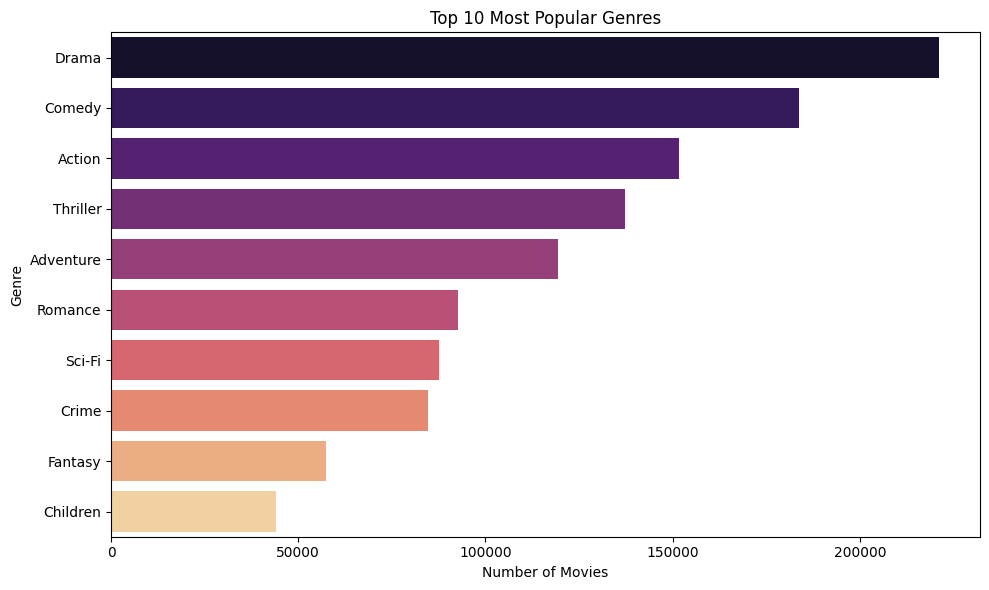

In [14]:
# Bargraph 5: Exploring movie recommendation by popular genres

popular_genres_pd = popular_genres.limit(10).toPandas()


plt.figure(figsize=(10, 6))
sns.barplot(x='movies_count', y='genre', data=popular_genres_pd, palette='magma')

# Set plot labels and title
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.title('Top 10 Most Popular Genres')

# Show the plot
plt.tight_layout()
plt.show()


In [15]:
# Goal 6 Recommendation Diversity: Ensure that the recommendation system covering different genres and types of movies.
ratings_df = df.select("userId", "movieId", "rating")
movies_df = df.select("movieId", "title", "genres").distinct()


genres_df = movies_df.withColumn("genre", explode(split(col("genres"), "\\|"))).select("movieId", "title", "genre")


train, test = ratings_df.randomSplit([0.8, 0.2], seed=42)


als = ALS(
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    nonnegative=True,
    implicitPrefs=False,
    coldStartStrategy="drop"
)
model = als.fit(train)


user_recommendations = model.recommendForAllUsers(10)


recommendations_exploded = user_recommendations.select(
    col("userId"),
    explode(col("recommendations")).alias("recommendation")
).select(
    col("userId"),
    col("recommendation.movieId").alias("movieId"),
    col("recommendation.rating").alias("predicted_rating")
)


recommendations_with_genres = recommendations_exploded.join(genres_df, on="movieId")


diverse_recommendations = recommendations_with_genres.groupBy("userId").agg(
    collect_list("genre").alias("recommended_genres"),
    collect_list("title").alias("recommended_movies")
)


diverse_recommendations.show(5, truncate=False)

+------+-----------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userId|recommended_genres                                                                                                                             |recommended_movies                                                                                                                                                                                                                                                                      

C:\Users\S564560\AppData\Local\Temp\ipykernel_5152\3141693524.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette="viridis")


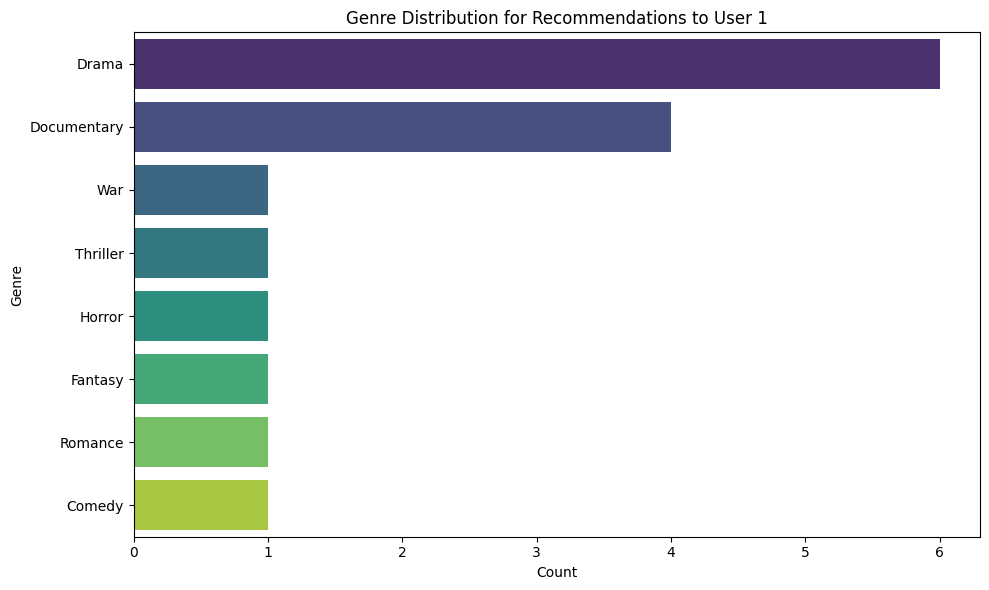

In [16]:
# Bargraph6: Genre Distribution for a Specific User
import matplotlib.pyplot as plt
import seaborn as sns


user_id = 1  
user_recommendations = diverse_recommendations.filter(col("userId") == user_id).toPandas()

if not user_recommendations.empty:
   
    genres = user_recommendations["recommended_genres"].iloc[0]
    genre_counts = pd.Series(genres).value_counts()

    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=genre_counts.values, y=genre_counts.index, palette="viridis")

   
    plt.xlabel("Count")
    plt.ylabel("Genre")
    plt.title(f"Genre Distribution for Recommendations to User {user_id}")

    
    plt.tight_layout()
    plt.show()
else:
    print(f"No recommendations available for User {user_id}")


In [24]:
# Goal 7 Latency optimization
data.cache()
 

top_rated = data.groupBy("movieId", "title").agg(avg("rating").alias("avg_rating")).orderBy("avg_rating", ascending=False)
 

top_rated.show(10)

+-------+--------------------+----------+
|movieId|               title|avg_rating|
+-------+--------------------+----------+
|     33|Wings of Courage ...|       5.0|
|  54341|Wild Tigers I Hav...|       5.0|
|  81020|Hedgehog, The (Le...|       5.0|
|  69699| Love Streams (1984)|       5.0|
| 123288|        Taken (2002)|       5.0|
|   4436|    Obsession (1976)|       5.0|
|  64408|Sun Shines Bright...|       5.0|
|  91007|I Want to Be a So...|       5.0|
| 127019|Line of Sight (2012)|       5.0|
| 184685|Legend of the Dem...|       5.0|
+-------+--------------------+----------+
only showing top 10 rows



C:\Users\S564560\AppData\Local\Temp\ipykernel_5152\3304434814.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="avg_rating", y="title", data=top_rated_pd, palette='viridis')


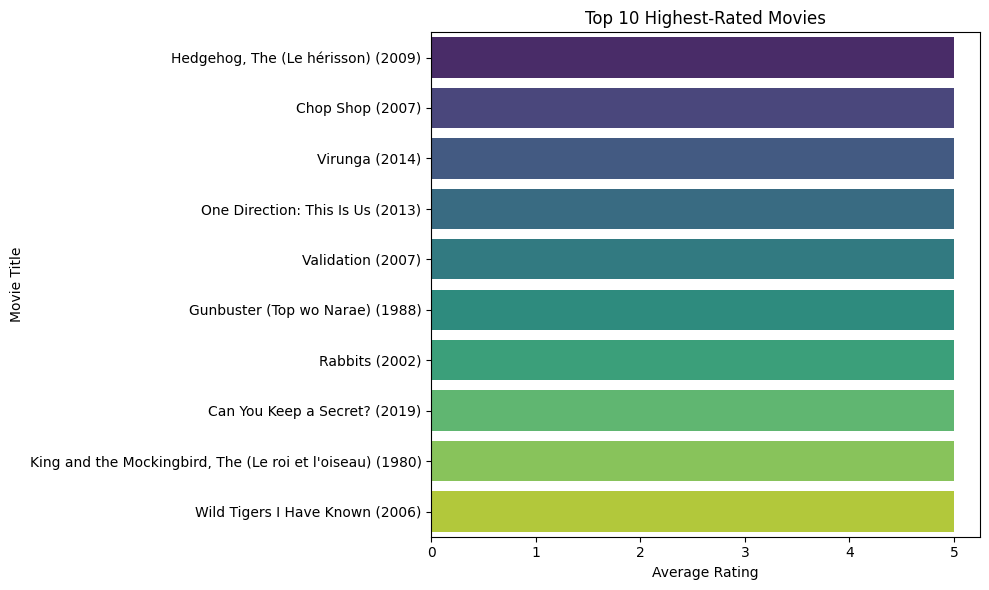

In [26]:
#Bargraph 7
import matplotlib.pyplot as plt
import seaborn as sns


data.cache()


top_rated = data.groupBy("movieId", "title").agg(avg("rating").alias("avg_rating")).orderBy("avg_rating", ascending=False)


top_rated_pd = top_rated.limit(10).toPandas()


plt.figure(figsize=(10, 6))
sns.barplot(x="avg_rating", y="title", data=top_rated_pd, palette='viridis')


plt.xlabel('Average Rating')
plt.ylabel('Movie Title')
plt.title('Top 10 Highest-Rated Movies')


plt.tight_layout()
plt.show()


In [27]:
# Goal 8 Data Quality assessment

data_quality_check = data.select(
    [count(col(c)).alias(f"{c}_non_null") for c in data.columns]
)
 

print("Data Quality Check - Non-Null Counts:")
data_quality_check.show()
 
# 2. Check for Duplicates

duplicates = data.groupBy("userId", "movieId").count().filter(col("count") > 1)
 

print("\nDuplicate Entries (userId, movieId pairs):")
duplicates.show()

Data Quality Check - Non-Null Counts:
+---------------+----------------+---------------+------------------+--------------+---------------+
|userId_non_null|movieId_non_null|rating_non_null|timestamp_non_null|title_non_null|genres_non_null|
+---------------+----------------+---------------+------------------+--------------+---------------+
|         508394|          508394|         508394|            508394|        508394|         508394|
+---------------+----------------+---------------+------------------+--------------+---------------+


Duplicate Entries (userId, movieId pairs):
+------+-------+-----+
|userId|movieId|count|
+------+-------+-----+
+------+-------+-----+



C:\Users\S564560\AppData\Local\Temp\ipykernel_5152\2867590268.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='non_null_count', y='column', data=data_quality_check_pd, palette='coolwarm')


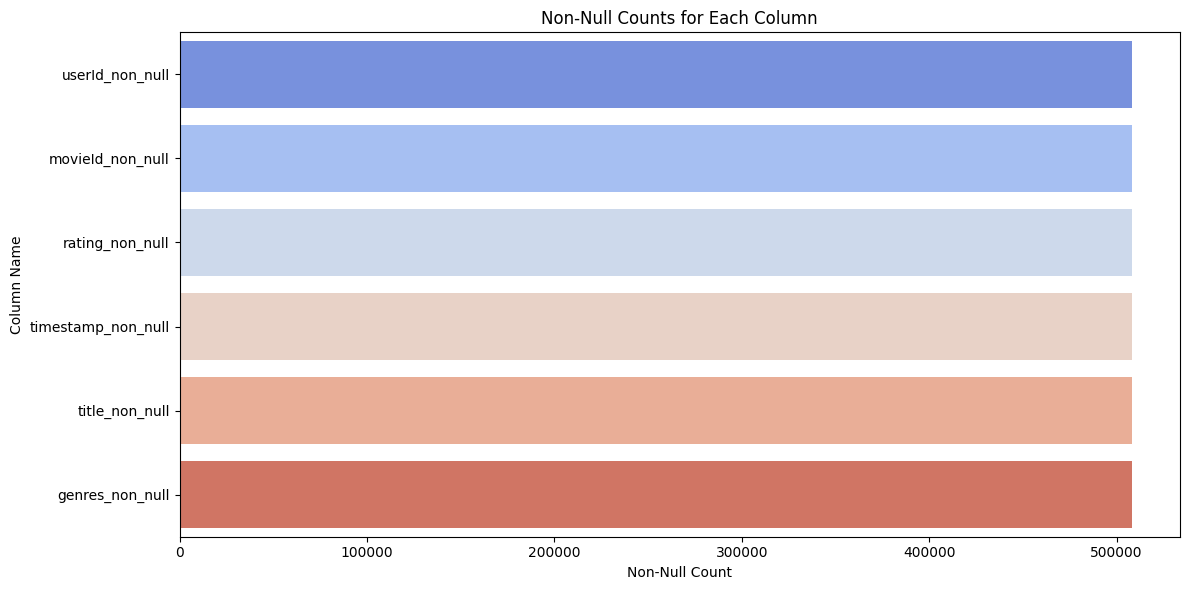

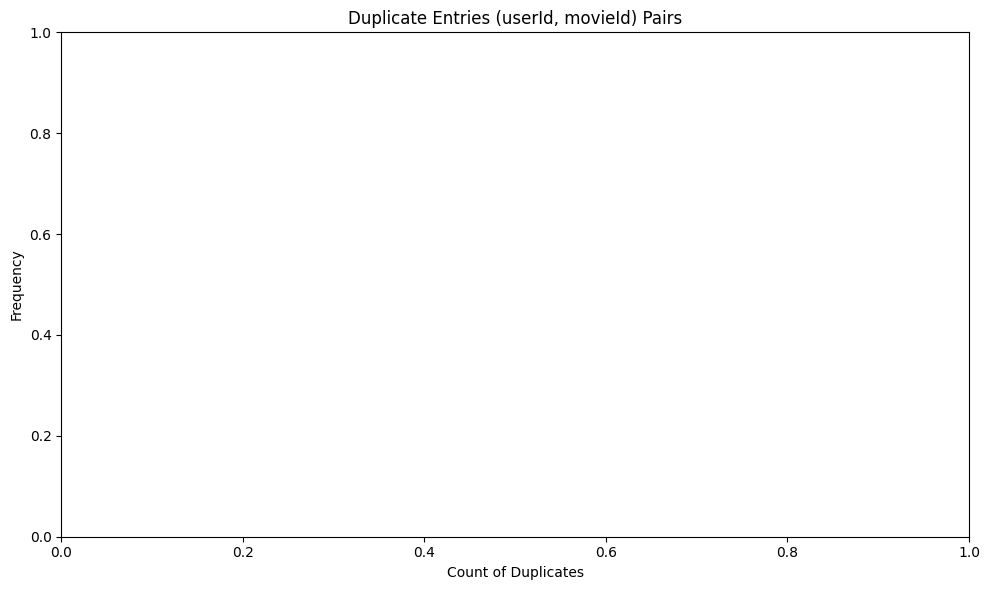

In [29]:
#8
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Quality Check - Non-Null Counts Visualization

data_quality_check_pd = data_quality_check.toPandas().T 
data_quality_check_pd.columns = ['non_null_count']
data_quality_check_pd = data_quality_check_pd.reset_index().rename(columns={'index': 'column'})


plt.figure(figsize=(12, 6))
sns.barplot(x='non_null_count', y='column', data=data_quality_check_pd, palette='coolwarm')
plt.title('Non-Null Counts for Each Column')
plt.xlabel('Non-Null Count')
plt.ylabel('Column Name')
plt.tight_layout()
plt.show()

# 2. Duplicates Visualization

duplicates_pd = duplicates.toPandas()


plt.figure(figsize=(10, 6))
sns.countplot(x='count', data=duplicates_pd, palette='viridis')
plt.title('Duplicate Entries (userId, movieId) Pairs')
plt.xlabel('Count of Duplicates')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
